# Домашнее задание к занятию "Улучшение качества обучения нейросети"


Цель задания: научиться использовать в коде различные методы Transfer Learning.

Задание:
На примере датасета персонажей мультфильма Симпсонов:

* Модифицируйте код обучения, используя различные типы LR Schedulers из Pytorch. Проведите минимум 2 эксперимента с разными шедулерами.
* Подберите аугментации train данных, при которых итоговое качество на валидации станет сильно хуже, чем полученное на занятии.
* Возьмите любую архитектуру (VGG, EfficientNet или MobileNet) и примените к ней методы, которые разбирались на занятии.
* Оформите вывод по результатам проведённых экспериментов.


### Импорт библиотек

In [ ]:
import os
import time
import glob

from tqdm.notebook import tqdm
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import torch
from torch import nn
import torch.nn.functional as F
from torchsummary import summary

import torchvision
from torchvision import transforms

from IPython.display import clear_output
%matplotlib inline

from torchvision.models import resnet18
from torchvision.models import ResNet18_Weights

from torchvision.models import EfficientNet_B6_Weights
from torchvision.models import EfficientNet_B0_Weights




sns.set(font_scale=1.2)
# # sns.set_style(style='whitegrid')
# device_num = 0
# torch.cuda.set_device(device_num)

### Загрузка данных

In [ ]:
# загрузим датасет со своего Google Drive

# предварительно необходимо скачать датасет с kaggle: https://www.kaggle.com/datasets/alexattia/the-simpsons-characters-dataset
# создать zip-архивы из папок simpsons_dataset и kaggle_simpson_testset
# и загрузить на свой google drive в папку netology_dl_sem

from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!mkdir -p data

!cp drive/MyDrive/netology_dl_sem/test.zip data/
!cp drive/MyDrive/netology_dl_sem/train.zip data/

!unzip -o -qq data/test.zip -d data/
!unzip -o -qq data/train.zip -d data/
!rm -rf data/simpsons_dataset/simpsons_dataset

In [ ]:
!rm -rf data/simpsons_dataset/simpsons_dataset

In [ ]:
# разделим картинки на train и val в отношении 70 на 30 для каждого класса
data_dir = "data/simpsons_dataset"
data_image_paths = glob.glob(f"{data_dir}/*/*.jpg")
data_image_labels = [path.split('/')[-2] for path in data_image_paths]
train_files_path, val_files_path = train_test_split(
    data_image_paths,
    test_size=0.3,
    stratify=data_image_labels
)

print(
    f"Изображений в train: {len(train_files_path)}\nИзображений в val: {len(val_files_path)}"
)

Изображений в train: 14653
Изображений в val: 6280


In [ ]:
input_size = 224

train_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ColorJitter(0.9, 0.9, 0.9),
    transforms.RandomAffine(5),
    transforms.ToTensor(),
])


val_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.ImageFolder(
    data_dir,
    transform=train_transform,
    is_valid_file=lambda x: x in train_files_path
)

val_dataset = torchvision.datasets.ImageFolder(
    data_dir,
    transform=val_transform,
    is_valid_file=lambda x: x in val_files_path
)

In [ ]:
print("Количество классов в train: ", len(train_dataset.classes))
print("Количество классов в val: ", len(val_dataset.classes))
print("Количество классов одинаково: ", len(train_dataset.classes) == len(val_dataset.classes))

Количество классов в train:  42
Количество классов в val:  42
Количество классов одинаково:  True


Посмотрим на изображения из `val` и `train`

In [ ]:
sns.set_style(style='white')

def show_images(dataset):
    fig, ax = plt.subplots(
        nrows=2, ncols=3, figsize=(8, 6),
        sharey=True, sharex=True
    )

    for fig_x in ax.flatten():
        idx = np.random.randint(low=0, high=6000)
        img, label = dataset[idx]
        fig_x.set_title(dataset.classes[label])
        fig_x.imshow(img.numpy().transpose((1, 2, 0)))

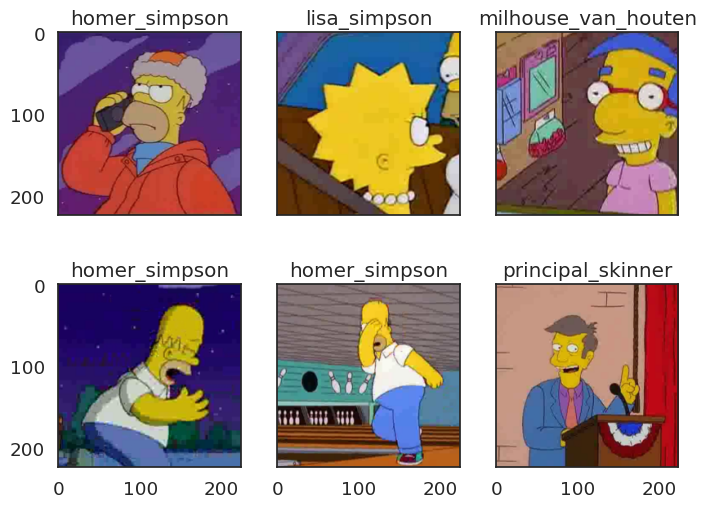

In [ ]:
show_images(val_dataset)

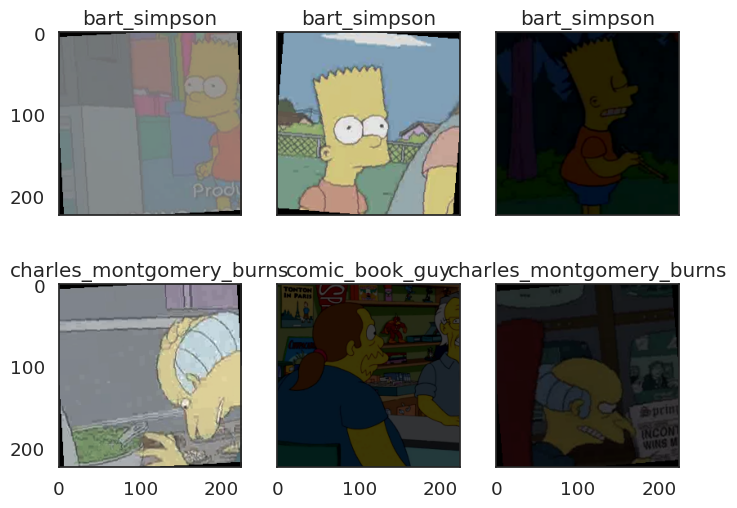

In [ ]:
show_images(train_dataset)

Невооруженным взглядом видно, что картинки из `train` выглядят немного изменёнными по сравнению с `val`. Опишем по пунктам, почему так происходит.

1. К `train` применялись дополнительные аугментации `ColorJitter` и `RandomAffine`, чтобы увеличить размер датасета и обобщающую способность сети.
2. К `val` никакие меняющие изображение аугментации не применялись, т.к. замерять метрику качества необходимо на настоящих данных.

**Создадим DataLoader-ы и функции для обучения**

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Функции

In [ ]:
def plot_learning_curves(history):
    '''
    Функция для вывода графиков лосса и метрики во время обучения.
    '''
    fig = plt.figure(figsize=(20, 7))

    plt.subplot(1,2,1)
    plt.title('Лосс', fontsize=15)
    plt.plot(history['loss']['train'], label='train')
    plt.plot(history['loss']['val'], label='val')
    plt.ylabel('лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()

    plt.subplot(1,2,2)
    plt.title('Точность', fontsize=15)
    plt.plot(history['acc']['train'], label='train')
    plt.plot(history['acc']['val'], label='val')
    plt.ylabel('лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()
    plt.show()

In [ ]:
def train(
    model,
    criterion,
    optimizer,
    train_batch_gen,
    val_batch_gen,
    num_epochs=10
):
    '''
    Функция для обучения модели и вывода лосса и метрики во время обучения.
    '''

    history = defaultdict(lambda: defaultdict(list))

    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0

        start_time = time.time()

        # устанавливаем поведение dropout / batch_norm  в обучение
        model.train(True)

        # на каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in train_batch_gen:
            # обучаемся на текущем батче
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)
            loss = criterion(logits, y_batch.long().to(device))

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            train_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            train_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # подсчитываем лоссы и сохраням в "историю"
        train_loss /= len(train_batch_gen)
        train_acc /= len(train_batch_gen)
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)

        # устанавливаем поведение dropout / batch_norm в режим тестирования
        model.train(False)

        # полностью проходим по валидационному датасету
        for X_batch, y_batch in val_batch_gen:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)
            loss = criterion(logits, y_batch.long().to(device))
            val_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            val_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # подсчитываем лоссы и сохраням в "историю"
        val_loss /= len(val_batch_gen)
        val_acc /= len(val_batch_gen)
        history['loss']['val'].append(val_loss)
        history['acc']['val'].append(val_acc)

        clear_output()

        # печатаем результаты после каждой эпохи
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))

        plot_learning_curves(history)

    return model, history

In [ ]:
batch_size = 64
# batch_size = 8


# не забудем перемешать train
train_batch_gen = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
# валидационный датасет мешать не нужно, а точнее бессмысленно
# сеть на нём не обучается
val_batch_gen = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False
)

### Обучим `Resnet18` с нуля

Epoch 10 of 10 took 197.904s
  training loss (in-iteration): 	1.826983
  validation loss (in-iteration): 	1.602347
  training accuracy: 			50.28 %
  validation accuracy: 			56.28 %


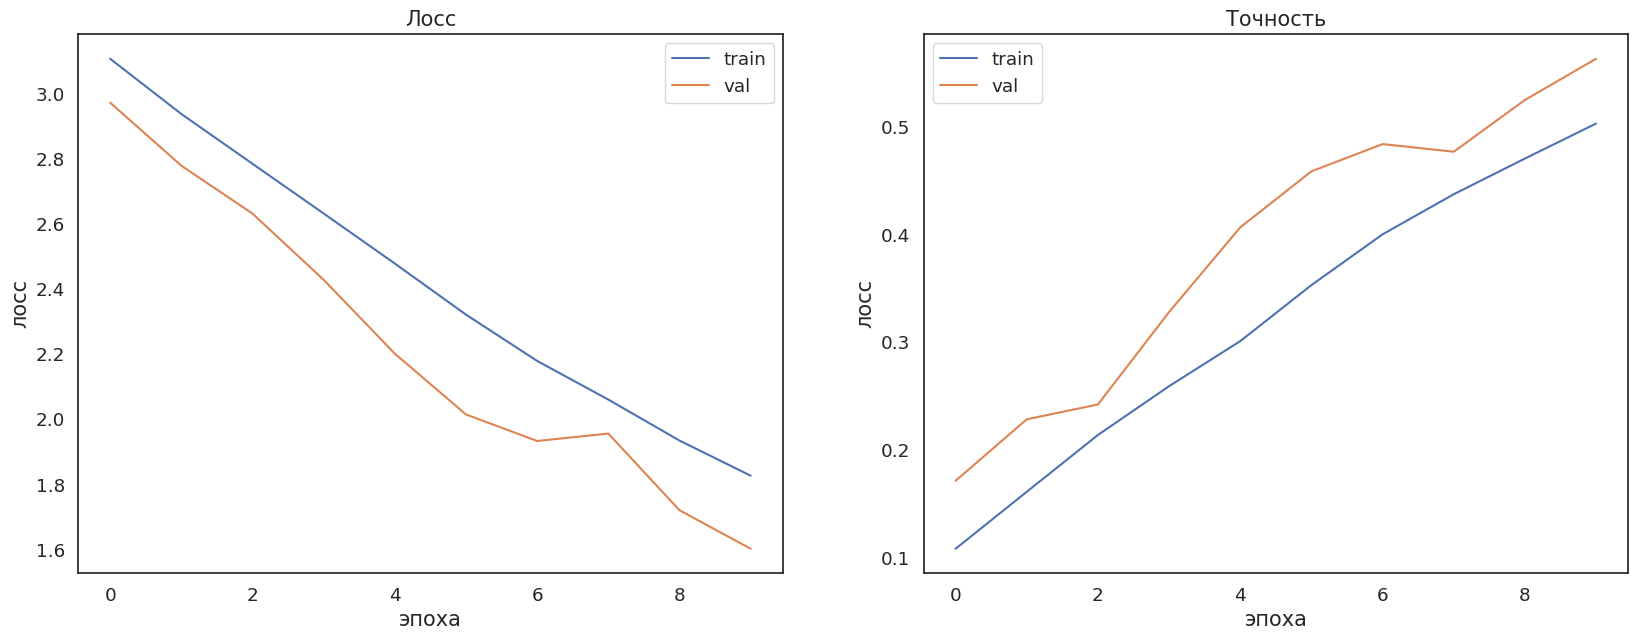

In [ ]:
model = resnet18(pretrained=False)
model.fc = nn.Linear(512, 42)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

clf_model, history = train(
    model, criterion, optimizer,
    train_batch_gen, val_batch_gen,
    num_epochs=10
)

### ResNet как `Feature Extractor`

Epoch 10 of 10 took 173.565s
  training loss (in-iteration): 	1.584347
  validation loss (in-iteration): 	1.384386
  training accuracy: 			59.69 %
  validation accuracy: 			65.42 %


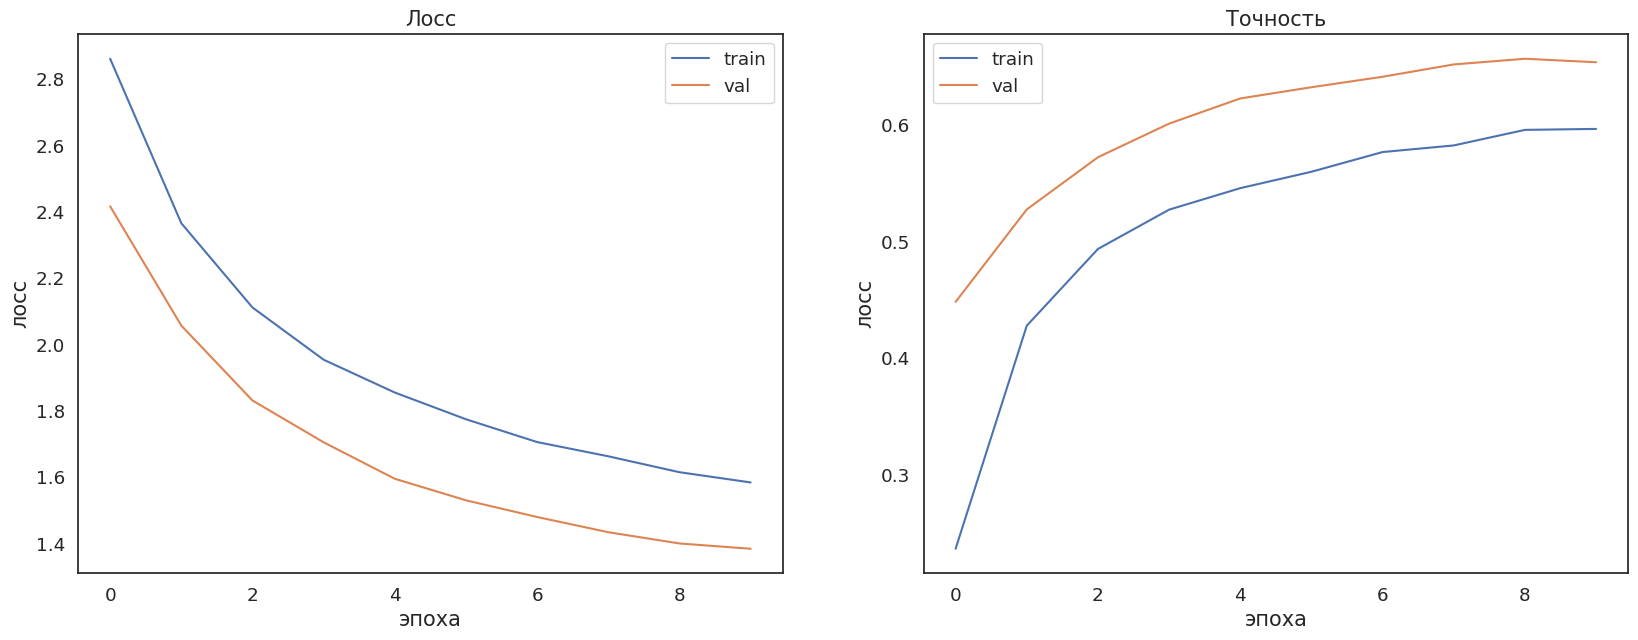

In [ ]:
# возьмём предобученную сеть
fe_model = resnet18(pretrained=True)

# заморозим все слои сети
for param in fe_model.parameters():
    param.requires_grad = False

# добавим над feature extractor сетью классификационный слой
fe_model.fc = nn.Linear(512, 42)
fe_model = fe_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(fe_model.parameters(), lr=0.01)

clf_model, history = train(
    fe_model, criterion, optimizer,
    train_batch_gen, val_batch_gen,
    num_epochs=10
)

### ResNet как `FineTuning`

Epoch 10 of 10 took 189.769s
  training loss (in-iteration): 	0.089878
  validation loss (in-iteration): 	0.233552
  training accuracy: 			97.81 %
  validation accuracy: 			94.92 %


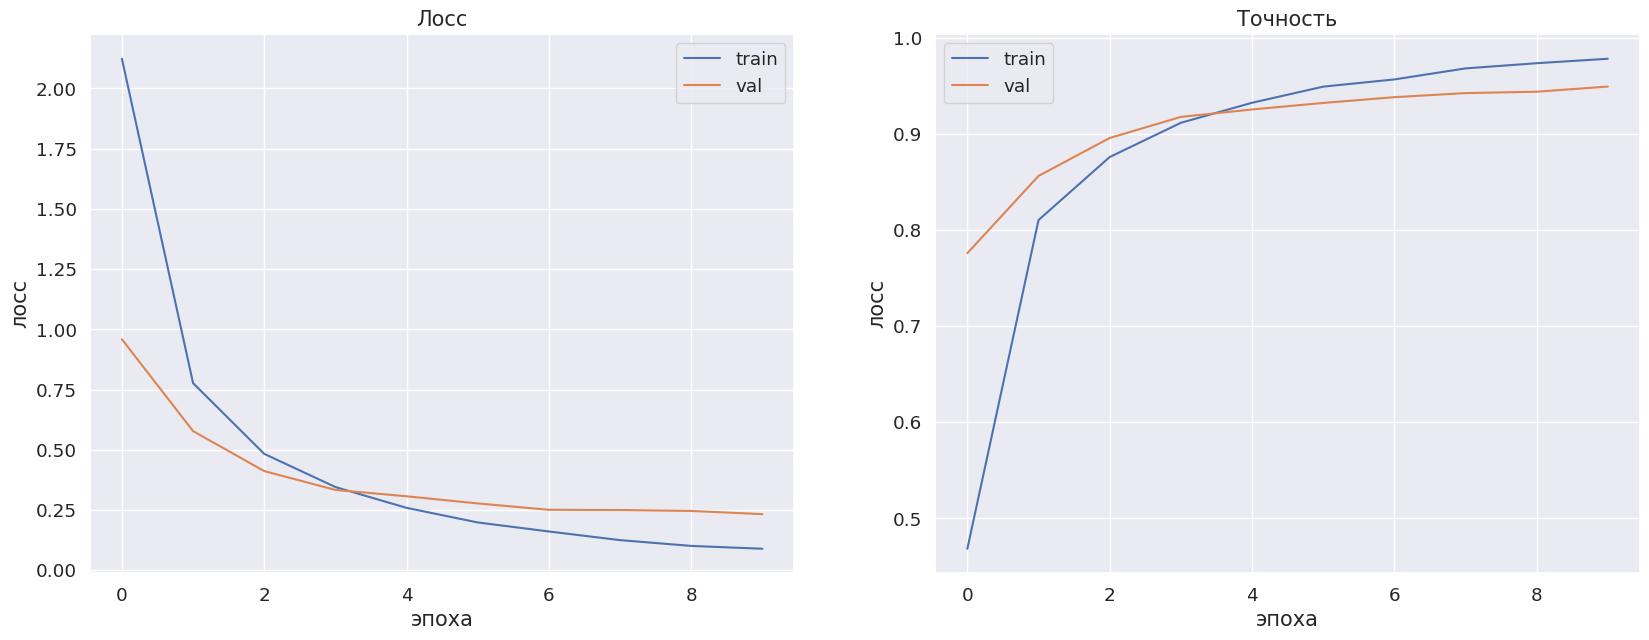

In [ ]:
fine_tuning_model = nn.Sequential()

fine_tuning_model.add_module('resnet', resnet18(pretrained=True))

# добавим новые слои для классификации для нашей конкретной задачи
fine_tuning_model.add_module('relu_1', nn.ReLU())
fine_tuning_model.add_module('fc_1', nn.Linear(1000, 512))
fine_tuning_model.add_module('relu_2', nn.ReLU())
fine_tuning_model.add_module('fc_2', nn.Linear(512, 42))

fine_tuning_model = fine_tuning_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(fine_tuning_model.parameters(), lr=0.01)

clf_model, history = train(
    fine_tuning_model, criterion, optimizer,
    train_batch_gen, val_batch_gen,
    num_epochs=10
)

##  LR Schedulers

### Функции для обучения с lr_scheduler

In [ ]:
def plot_learning_curves(history):
    '''
    Функция для вывода графиков лосса и метрики во время обучения.
    '''
    plt.figure(figsize=(15, 5))

    plt.subplot(1,3,1)
    plt.title('Лосс', fontsize=8)
    plt.plot(history['loss']['train'], label='train')
    plt.plot(history['loss']['val'], label='val')
    plt.ylabel('лосс', fontsize=8)
    plt.xlabel('эпоха', fontsize=8)
    plt.legend(fontsize=5)

    plt.subplot(1,3,2)
    plt.title('Точность', fontsize=8)
    plt.plot(history['acc']['train'], label='train')
    plt.plot(history['acc']['val'], label='val')
    plt.ylabel('лосс', fontsize=8)
    plt.xlabel('эпоха', fontsize=8)
    plt.legend(fontsize=5)
    # plt.show()

    plt.subplot(1,3,3)
    plt.title("learning vs. epoch", fontsize=8)
    plt.plot(history['lr']['step'], label='steps')
    plt.xlabel("эпоха", fontsize=8)
    plt.ylabel("learning rate", fontsize=8)
    plt.legend(fontsize=5)
    plt.show()




In [ ]:
def train(
    model,
    criterion,
    optimizer,
    scheduler,
    train_batch_gen,
    val_batch_gen,
    num_epochs=3
):
    '''
    Функция для обучения модели и вывода лосса и метрики во время обучения.
    '''

    history = defaultdict(lambda: defaultdict(list))
    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0

        start_time = time.time()

        # print('Initial learning rate: {}'.format(optimizer.state_dict()['param_groups'][0]['lr']))
        # устанавливаем поведение dropout / batch_norm  в обучение
        model.train(True)

        # на каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in train_batch_gen:
            # обучаемся на текущем батче
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)
            loss = criterion(logits, y_batch.long().to(device))

            loss.backward()
            optimizer.step()


            optimizer.zero_grad()

            train_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            train_acc += np.mean(y_batch.cpu().numpy() == y_pred)


        # подсчитываем лоссы и сохраням в "историю"

        train_loss /= len(train_batch_gen)
        train_acc /= len(train_batch_gen)
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)


        # устанавливаем поведение dropout / batch_norm в режим тестирования
        model.train(False)

        # полностью проходим по валидационному датасету
        for X_batch, y_batch in val_batch_gen:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)
            loss = criterion(logits, y_batch.long().to(device))
            val_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            val_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # подсчитываем лоссы и сохраням в "историю"
        val_loss /= len(val_batch_gen)
        val_acc /= len(val_batch_gen)
        history['loss']['val'].append(val_loss)
        history['acc']['val'].append(val_acc)

        scheduler.step()
        history['lr']['step'].append(optimizer.state_dict()['param_groups'][0]['lr'])


        clear_output()

        # печатаем результаты после каждой эпохи
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))
        print("  learning rate: \t\t\t{:.4f}".format(optimizer.state_dict()['param_groups'][0]['lr']))


        plot_learning_curves(history)

    return model, history

### ResNet как `FineTuning` + StepLR

In [ ]:
fine_tuning_model = nn.Sequential()

fine_tuning_model.add_module('resnet', resnet18(weights=ResNet18_Weights.IMAGENET1K_V1))

# добавим новые слои для классификации для нашей конкретной задачи
fine_tuning_model.add_module('relu_1', nn.ReLU())
fine_tuning_model.add_module('fc_1', nn.Linear(1000, 512))
fine_tuning_model.add_module('relu_2', nn.ReLU())
fine_tuning_model.add_module('fc_2', nn.Linear(512, 42))

fine_tuning_model = fine_tuning_model.to(device)

Epoch 10 of 10 took 167.262s
  training loss (in-iteration): 	0.007067
  validation loss (in-iteration): 	0.172388
  training accuracy: 			99.82 %
  validation accuracy: 			96.51 %
  learning rate: 			0.0000


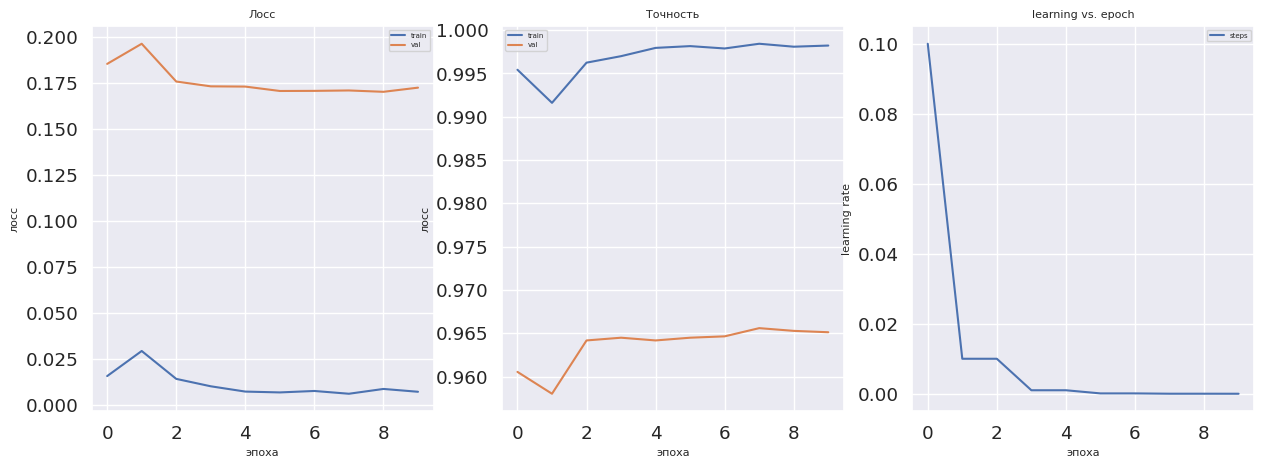

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(fine_tuning_model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.8)

clf_model_stepLRtepLR, history_clf_model_stepLRtepLR = train(
    fine_tuning_model, criterion, optimizer, scheduler,
    train_batch_gen, val_batch_gen,
    num_epochs=10
)

### ResNet как FineTuning + CosineAnnealingLR

Epoch 10 of 10 took 171.152s
  training loss (in-iteration): 	0.017014
  validation loss (in-iteration): 	0.200593
  training accuracy: 			99.51 %
  validation accuracy: 			96.04 %
  learning rate: 			0.0500


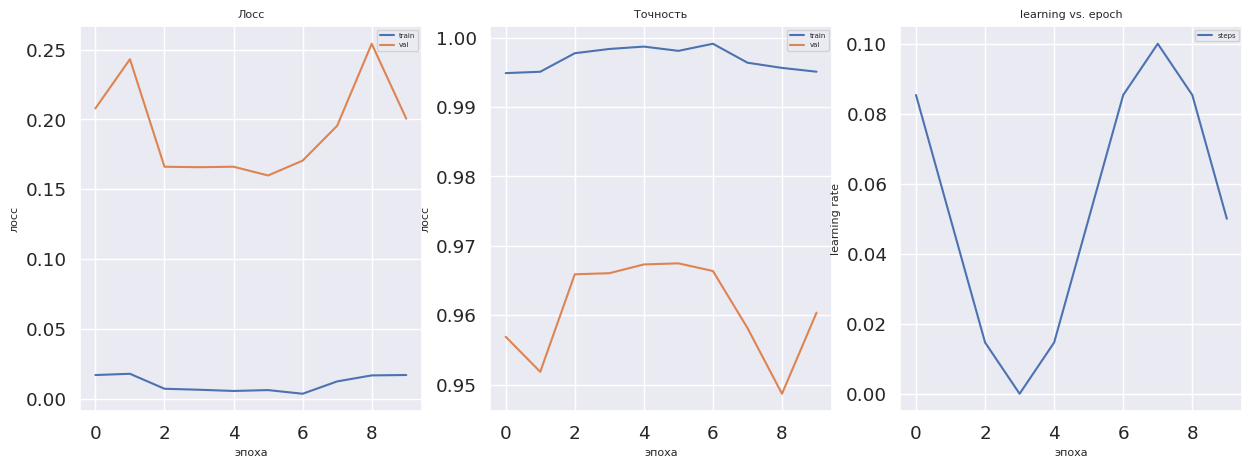

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(fine_tuning_model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=4)

# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

clf_model_CosineAnnealingLR, history_clf_model_CosineAnnealingLR = train(
    fine_tuning_model, criterion, optimizer, scheduler,
    train_batch_gen, val_batch_gen,
    num_epochs=10
)


## Подбор Аугментации

In [ ]:
input_size = (224, 224)

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p = 0.25),
    # transforms.Grayscale(3),
    transforms.GaussianBlur(kernel_size=(7, 13), sigma=(0.1, 0.2)),
    transforms.Resize(input_size),

    # transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0),
    # transforms.CenterCrop(input_size),
    # transforms.ColorJitter(0.9, 0.9, 0.9),
    # transforms.RandomAffine(5),
    transforms.ToTensor(),
])


val_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.ImageFolder(
    data_dir,
    transform=train_transform,
    is_valid_file=lambda x: x in train_files_path
)

val_dataset = torchvision.datasets.ImageFolder(
    data_dir,
    transform=val_transform,
    is_valid_file=lambda x: x in val_files_path
)

In [ ]:
batch_size = 64
# batch_size = 8


# не забудем перемешать train
train_batch_gen = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
# валидационный датасет мешать не нужно, а точнее бессмысленно
# сеть на нём не обучается
val_batch_gen = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
sns.set_style(style='white')

def show_images(dataset):
    fig, ax = plt.subplots(
        nrows=2, ncols=3, figsize=(8, 6),
        sharey=True, sharex=True
    )

    for fig_x in ax.flatten():
        idx = np.random.randint(low=0, high=6000)
        img, label = dataset[idx]
        fig_x.set_title(dataset.classes[label])
        fig_x.imshow(img.numpy().transpose((1, 2, 0)))

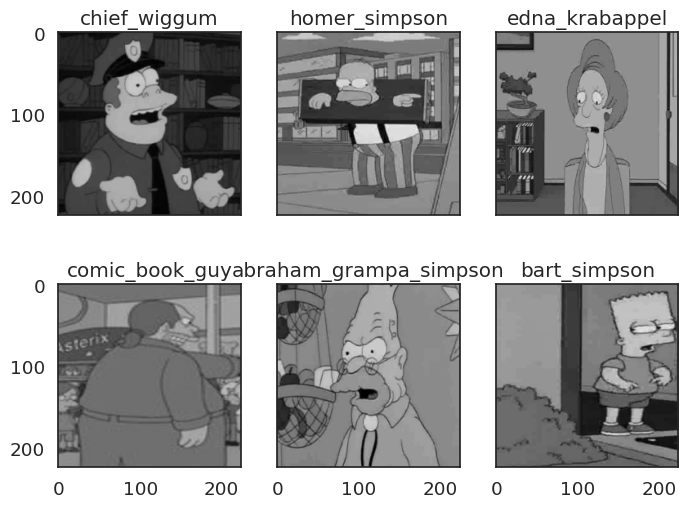

In [ ]:
show_images(train_dataset)

Epoch 10 of 10 took 114.669s
  training loss (in-iteration): 	1.425124
  validation loss (in-iteration): 	6.155706
  training accuracy: 			63.23 %
  validation accuracy: 			6.00 %


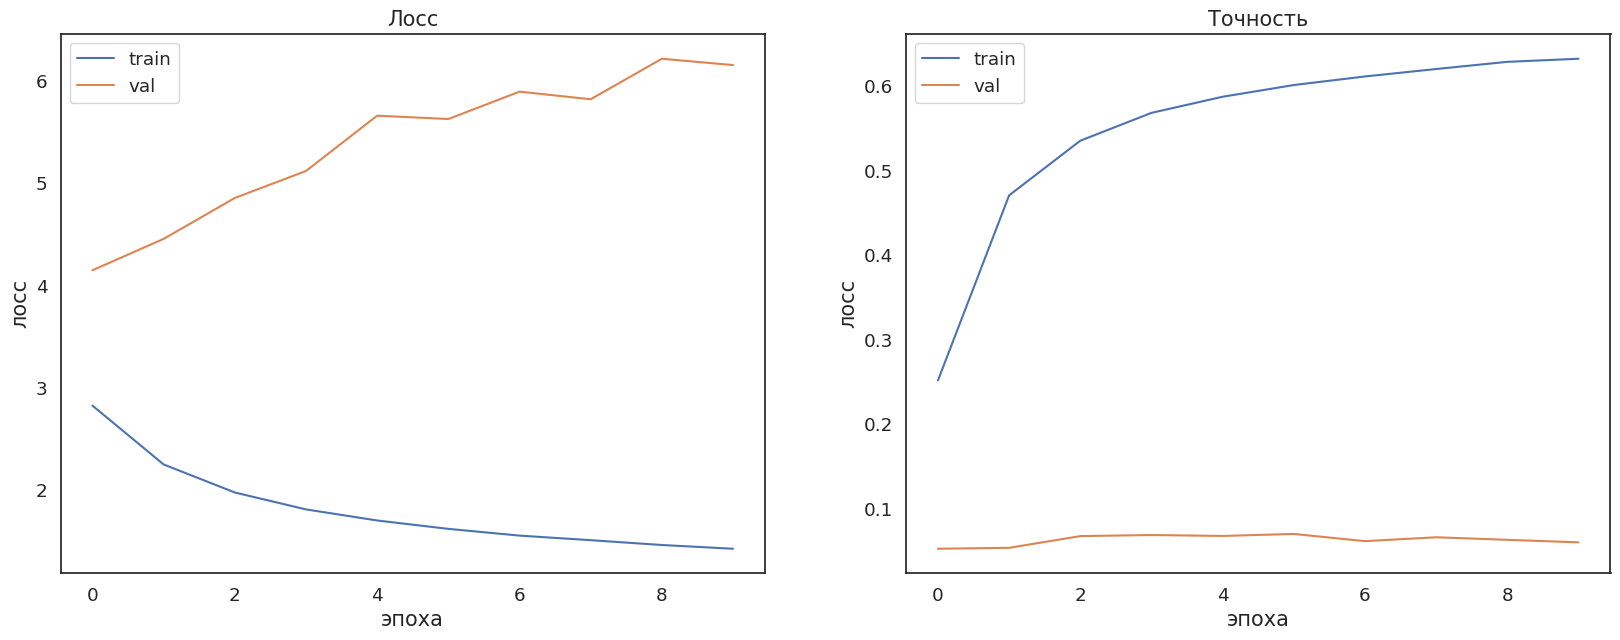

In [ ]:
# возьмём предобученную сеть
fe_model = resnet18(pretrained=True)

# заморозим все слои сети
for param in fe_model.parameters():
    param.requires_grad = False

# добавим над feature extractor сетью классификационный слой
fe_model.fc = nn.Linear(512, 42)
fe_model = fe_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(fe_model.parameters(), lr=0.01)

clf_model, history = train(
    fe_model, criterion, optimizer,
    train_batch_gen, val_batch_gen,
    num_epochs=10
)

## Transfer Learning  - EfficientNet

### Efficient с нуля

In [ ]:
model_efficient = torchvision.models.efficientnet_b0(weights= None)
model_efficient

In [ ]:
# model_efficient = torchvision.models.efficientnet_b6(weights= None)
model_efficient.classifier[1] = nn.Linear(1280, 42)

model_efficient = model_efficient.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_efficient.parameters(), lr=0.01)

clf_model, history = train(
    model_efficient, criterion, optimizer,
    train_batch_gen, val_batch_gen,
    num_epochs=10
)

Недостаточно ресурсов для обучения с нуля.

OutOfMemoryError: CUDA out of memory. Tried to allocate 84.00 MiB (GPU 0; 14.75 GiB total capacity; 13.33 GiB already allocated; 72.81 MiB free; 13.63 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

### EfficientNet как Feature Extracor

Epoch 10 of 10 took 145.213s
  training loss (in-iteration): 	1.963036
  validation loss (in-iteration): 	1.670317
  training accuracy: 			53.77 %
  validation accuracy: 			62.58 %


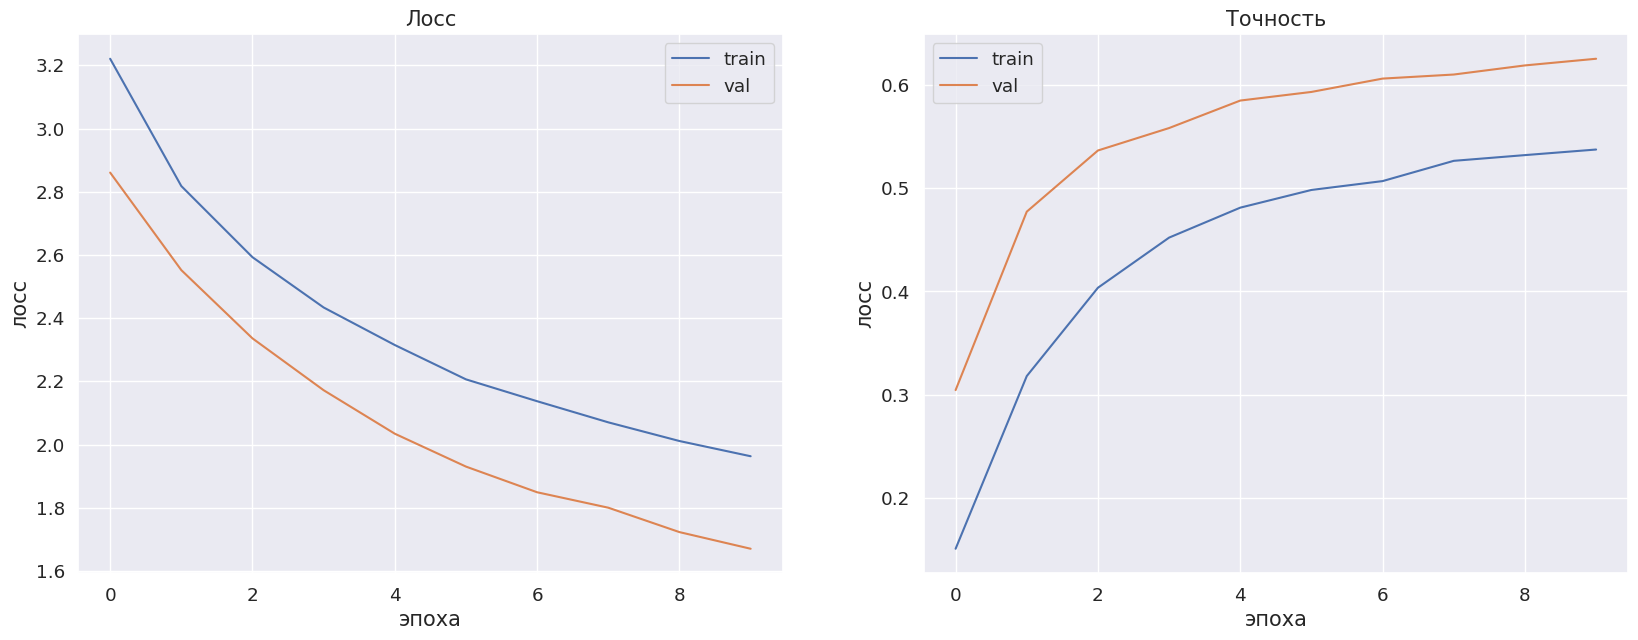

In [ ]:
# возьмём предобученную сеть
model_efficient_fe = torchvision.models.efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)

# заморозим все слои сети
for param in model_efficient_fe.parameters():
    param.requires_grad = False

# добавим над feature extractor сетью классификационный слой
model_efficient_fe.classifier[1] = nn.Linear(1280, 42)

model_efficient_fe = model_efficient_fe.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_efficient_fe.parameters(), lr=0.01)

clf_model, history = train(
    model_efficient_fe, criterion, optimizer,
    train_batch_gen, val_batch_gen,
    num_epochs=10
)

history_fe = history

### EfficientNet как FineTuning

In [ ]:
model_efficient_ft = nn.Sequential()

model_efficient_ft.add_module('efficientnet', torchvision.models.efficientnet_b6(weights=EfficientNet_B6_Weights.IMAGENET1K_V1))

# заморозим все слои сети
for param in model_efficient_ft.parameters():
    param.requires_grad = False

# добавим новые слои для классификации для нашей конкретной задачи
model_efficient_ft.add_module('relu_1', nn.ReLU())
model_efficient_ft.add_module('fc_1', nn.Linear(1000, 2304))
model_efficient_ft.add_module('relu_2', nn.ReLU())
model_efficient_ft.add_module('fc_2', nn.Linear(2304, 42))

model_efficient_ft = model_efficient_ft.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_efficient_ft.parameters(), lr=0.01)

clf_model, history = train(
    model_efficient_ft, criterion, optimizer,
    train_batch_gen, val_batch_gen,
    num_epochs=10)

history_ft = history

OutOfMemoryError: ignored

## Выводы

1. С использованием LR Schedulers обучение происходит намного эффективнее, качество значительно возрастает. Можно отследить тенденции обучения модели для подбора гиперпараметров.

2. При выборе аугментации важно понимать какие факторы могут сильно исказить результат обучения (изменение цветов, ротация и пр.), например если обучаться на черно-белых картинках, или с применением фильтров (гаусса и пр.), а валидитроваться на исходных цвкетных, то точность будет очень плохой.

3. При использовании общедоступных популярных моделей для transfer learning, обучение с нуля требует огромных ресурсов, мне не удалось обучить варианты efficientnet_b* с нуля в collab - "out of memory". Хватило ресурсов только для FeatureExtractor efficientnet_b0. Результат получился не очень высокий, возможно увеличение количества эпох и другие эксперименты с гиперпараметрами привели бы к лучшему результату.